# Dependencies 

## Imports 

In [5]:
# imports 
# base python
import os
import copy
from sys import getsizeof
import re

# scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, interp2d
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import preprocessing
import matplotlib.tri as tri

plt.rcParams["figure.figsize"] = (20,7)

#ase
from ase.io import gen, vasp, xyz, extxyz, dftb
from ase.io.dftb import read_dftb_velocities, write_dftb_velocities
from ase.calculators.dftb import Dftb
from ase import Atoms, Atom
from ase.constraints import FixAtoms
from ase.visualize import view
from ase.build import make_supercell
from ase.visualize.plot import plot_atoms
from ase.build import add_adsorbate
import nglview
from ase.geometry.analysis import Analysis

#dscribe
from dscribe.descriptors import SOAP
from dscribe.descriptors import MBTR
from dscribe.kernels import REMatchKernel
from dscribe.kernels import AverageKernel

from sklearn import preprocessing


#quippy 
from ase.build import bulk
from ase.optimize import LBFGS
from ase.visualize import view
from quippy.potential import Potential


#misc
import similaritymeasures


## Functions

In [6]:
def show_atoms_grid(data, rotation = '-0x,0y,0z', save= False, filename = 'grid_configs'):
    '''
    Where data is list of Atoms objects
    '''
    dim = int(np.ceil(np.sqrt(len(data))))
    fig, axarr = plt.subplots(dim, dim, figsize=(25, 25))
    for i, config in enumerate(data):
        plot_atoms(config, axarr[i%dim,i//dim], rotation = rotation)
    if save:
        fig.savefig(filename + ".png")
        
def normalize(y,x):
    """
    Takes y, x of data and returns normalized y
    """
    return y/np.trapz(y,x)

def KE(v_tot):
    "Returns KE of Ar+ in eV given total velocity"
    return 6.24E18 * 0.5 * 1.66E-27*39.95*(v_tot*1E5)**2

def v_from_KE(E):
    "Returns v(z) of Ar+ in eV given KE"
    return np.sqrt(E/(6.24E18 * 0.5 * 1.66E-27*39.95))/1E5

## Structures

In [7]:
mef = vasp.read_vasp("reference_files/CONTCAR_mef")
cf4 = vasp.read_vasp("reference_files/CONTCAR_cf4")
amorphous = vasp.read_vasp("reference_files/CONTCAR_amorphous_cubic")
xtl_n = vasp.read_vasp("reference_files/CONTCAR_nrich")
xtl_si = vasp.read_vasp("reference_files/CONTCAR_sirich")
xtl2x2 = gen.read_gen("reference_files/2x2xtl.gen")
heavy_bomb = vasp.read_vasp("reference_files/CONTCAR_heavy_bombard")
bulk222 = vasp.read_vasp("reference_files/CONTCAR_222bulk")

# Bond counting

Read in data, gen for final structs and .xyz files for trajectories; starts as generator object. Store as Series

In [8]:
datadir = "../1MLv0.135/" #1ML bombardment, 0.13 AA/ps = 35 eV, 0.135 Å/ps = 37.7 eV
trajectories = {}
geometries = {}
for i in os.listdir(datadir):
    if ".xyz" in i:
        key = re.search(r"\d+", i).group(0)
        trajectories[key] = xyz.read_xyz(datadir + i , index = slice(0,-1))
    if ".gen" in i:
        key = re.search(r"\d+", i).group(0)
        geometries[key] = gen.read_gen(datadir + i)
trajectories = pd.Series(trajectories)
geometries = pd.Series(geometries)

Store trajectories as arrays, not generators:

In [9]:
temp = {i:[frame for frame in traj] for i, traj in trajectories.iteritems()}
temp = pd.Series([[frame for frame in traj] for traj in trajectories], 
                 index = [i for i in trajectories.index])
trajectories = temp

View a couple examples:

In [24]:
view(np.random.choice(geometries), viewer = 'x3d')

In [36]:
view(np.random.choice(trajectories))

Get trajectory lengths:

In [43]:
trajlens = [len(i) for i in trajectories]
trajlens

[2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000]

Reference bond counts:

In [60]:
baseAnalysis = Analysis(xtl2x2)
baseNHbondcount = len(baseAnalysis.get_bonds("N", "H")[0])
baseNHbondcount

48

In [47]:
geomAnalyses = [Analysis(i) for i in geometries]

In [49]:
cfbonds = [i.get_bonds("C", "F")[0] for i in geomAnalyses]

cfbondCounts = [len(i) for i in cfbonds]
cfbondCounts

[11, 12, 11, 12, 11, 12, 12, 12, 12, 11, 12, 12, 12, 12]

In [39]:
sifBonds = [i.get_bonds("Si", "F")[0] for i in longgeomAnalysis]
sifBondCounts = [len(i) for i in sifBonds]
sifBondCounts

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [42]:
hfBonds = [i.get_bonds("H", "F")[0] for i in longgeomAnalysis]
hfBondCounts = [len(i) for i in hfBonds]
hfBondCounts

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [44]:
fBondSum = [i + j + k for i, j, k in zip(cfbondCounts, sifBondCounts, hfBondCounts)]
fBondSum

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]

In [45]:
chBonds = [i.get_bonds("C", "H")[0] for i in longgeomAnalysis]
chBondCounts = [len(i) for i in chBonds]
chBondCounts

[35, 36, 36, 36, 37, 36, 36, 36, 36, 36, 36, 36, 36, 36]

In [54]:
nhBonds = [i.get_bonds("N", "H")[0] for i in longgeomAnalysis]
nhBondCounts = [len(i) for i in nhBonds]
nhBondCounts

[48, 48, 48, 48, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48]

In [ ]:
pd.DataFrame({"CF":cfbon})

# SOAP comparison

In [199]:
soapGeoms = geometries
for atoms in soapGeoms:
    del atoms[[atom.index for atom in atoms if atom.symbol=='Ar']]
desc = SOAP(species=[1, 7, 14, 6, 9], 
             rcut=5.0, 
             nmax=10, 
             lmax=9, 
             sigma=.5, 
             periodic=True, 
             crossover=True, 
             sparse=False)
features = [preprocessing.normalize(desc.create(i)) for i in geometries]
bulkfeatures = preprocessing.normalize(desc.create(bulk222))

In [195]:
features[0].shape

(356, 8250)

In [196]:
bulkfeatures.shape

(168, 8250)

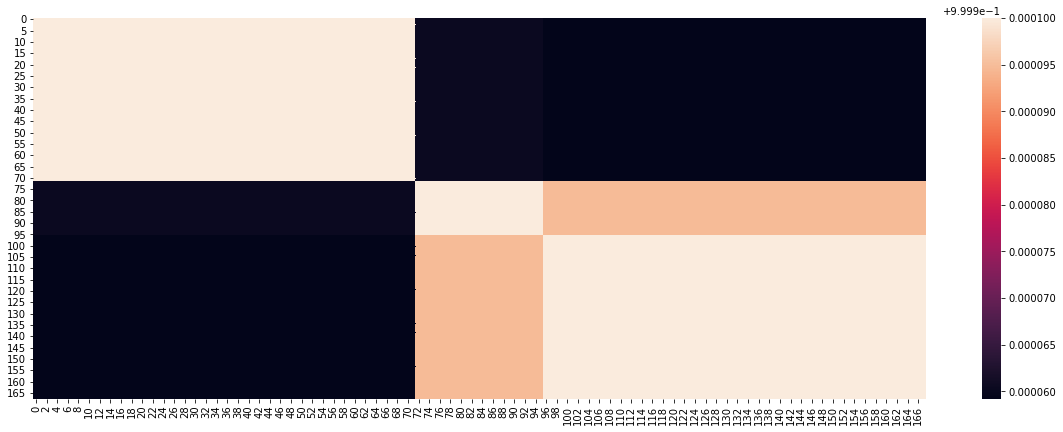

In [197]:
ax = sns.heatmap(rbf_kernel(bulkfeatures, bulkfeatures))

The above shows that SOAP identifies three types of atoms; Si, N (z planar), N (other). I suppose I'll use the N(other) as a reference for N atoms in the slabs...

In [184]:
siref = bulkfeatures[0].reshape(1, -1)
nref = bulkfeatures[-1].reshape(1, -1)

In [185]:
rbf_kernel(siref, nref)

array([[0.9997596]], dtype=float32)

In [186]:
siSimilarities = [rbf_kernel(siref, i)[0] for i in features]
nSimilarities = [rbf_kernel(nref, i)[0] for i in features]

In [187]:
vizStructs = []
for i, geom in enumerate(geometries):
    temp = geom.copy()
    charges = []
    for j, atom in enumerate(temp):
        if atom.symbol == "Si":
            charges.append(siSimilarities[i][j])
        elif atom.symbol == "N":
            charges.append(nSimilarities[i][j])
        else:
            charges.append(0)
    charges = np.array(charges)
    del temp[[atom.index for atom in geom if atom.symbol not in ['Si', 'N']]]
    charges = charges[[atom.index for atom in geom if atom.symbol in ['Si', 'N']]]
#     print(charges)
#     print(len(charges))
#     print(len(temp))
    temp.set_initial_charges(charges)
    vizStructs.append(temp)

In [188]:
view(vizStructs)